# Bca problem
### Initialization

In [1]:
import numpy as np
from pymor.basic import *
from pymor.parameters.functionals import ExpressionParameterFunctional
#import time

# For ANN
from pymor.reductors.neural_network import NeuralNetworkReductor
import torch.optim as optim

# For ROM
from pymor.reductors.coercive import CoerciveRBReductor
from pymor.algorithms.greedy import rb_greedy

In [2]:
set_defaults({'pymor.discretizers.builtin.gui.jupyter.get_visualizer.backend': 'MPL'})

### Define Problem

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

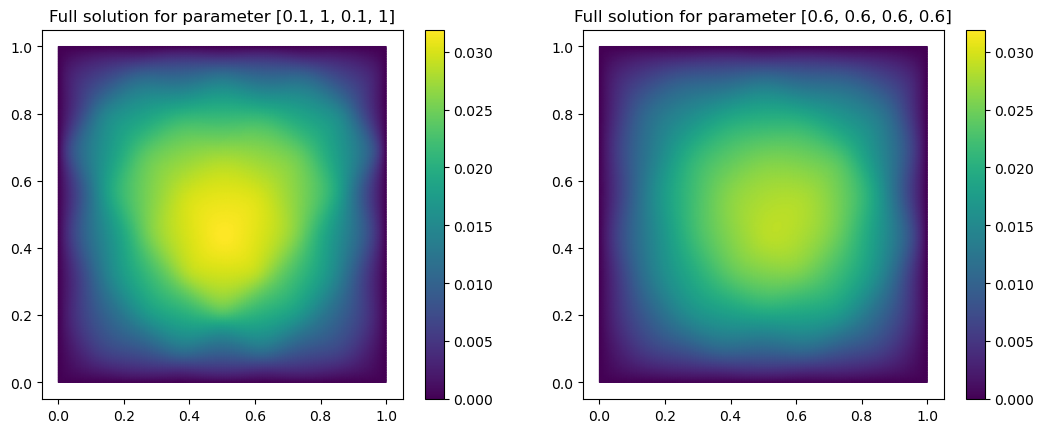

In [3]:
# define wave problem 5

# scale arguments of cos and sin by π to get more oscillations and thus more interesting patterns
# offset waves by only 1.1 (instead of recommended 2) to make patterns more visible (still strictly positive because e₀ ≥ 1 and μ₀ ≥ 0.1)

p0 = ProjectionParameterFunctional('diffusion', size = 4, index = 0)
p1 = ProjectionParameterFunctional('diffusion', size = 4, index = 1)
p2 = ProjectionParameterFunctional('diffusion', size = 4, index = 2)
p3 = ProjectionParameterFunctional('diffusion', size = 4, index = 3)


e0 = ExpressionFunction('1.1 + cos(x[0]*(2**0)*pi) * sin(x[1]*(2**0)*pi)', 2)
e1 = ExpressionFunction('1.1 + cos(x[0]*(2**1)*pi) * sin(x[1]*(2**1)*pi)', 2)
e2 = ExpressionFunction('1.1 + cos(x[0]*(2**2)*pi) * sin(x[1]*(2**2)*pi)', 2)
e3 = ExpressionFunction('1.1 + cos(x[0]*(2**3)*pi) * sin(x[1]*(2**3)*pi)', 2)

problem = StationaryProblem(
    domain = RectDomain(),
    rhs = ConstantFunction(dim_domain = 2, value = 1.),
    diffusion = LincombFunction([e0, e1, e2, e3],
                                [p0, p1, p2, p3]),
    parameter_ranges = (0.1, 1.),
)

fom, data = discretize_stationary_cg(problem, diameter = 1/200)

mu = [0.1,1,0.1,1]
mu2 = [0.6, 0.6, 0.6, 0.6]
U1 = fom.solve(mu)
U2 = fom.solve(mu2)

fom.visualize(
    (U1, U2), 
    legend = (
        f"Full solution for parameter {mu}",
        f"Full solution for parameter {mu2}",
    ),
)

### Building Reduced Order Models:

In [4]:
basis_size = 10

parameter_space = fom.parameters.space((0.1, 1))

training_set = parameter_space.sample_uniformly(3) #initially 100
validation_set = parameter_space.sample_randomly(20)

In [5]:
# Artificial Neural Network Reduced Model

#start_ann = time.perf_counter() # measure training time

ann_reductor = NeuralNetworkReductor(
    fom, training_set, validation_set, basis_size = basis_size, ann_mse = None #initially l2_err=1e-5, ann_mse=1e-5
)

ann_rom = ann_reductor.reduce(#hidden_layers = [27, 28, 29], 
                              restarts=10, optimizer = optim.LBFGS, epochs = 15000, learning_rate = 1, log_loss_frequency = 10)

#ann_train = time.perf_counter() - start_ann # measure training time

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [6]:
# Coercive RB Model

# start_rb = time.perf_counter() # measure training time

rb_reductor = CoerciveRBReductor(
    fom,
    product=fom.h1_0_semi_product,
    coercivity_estimator=ExpressionParameterFunctional('min(diffusion)',
                                                       fom.parameters)
)
greedy_data = rb_greedy(fom, rb_reductor, training_set, #initially 1000
                        max_extensions = basis_size)
rb_rom = greedy_data['rom']

# rb_train = time.perf_counter() - start_rb # measure training time

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

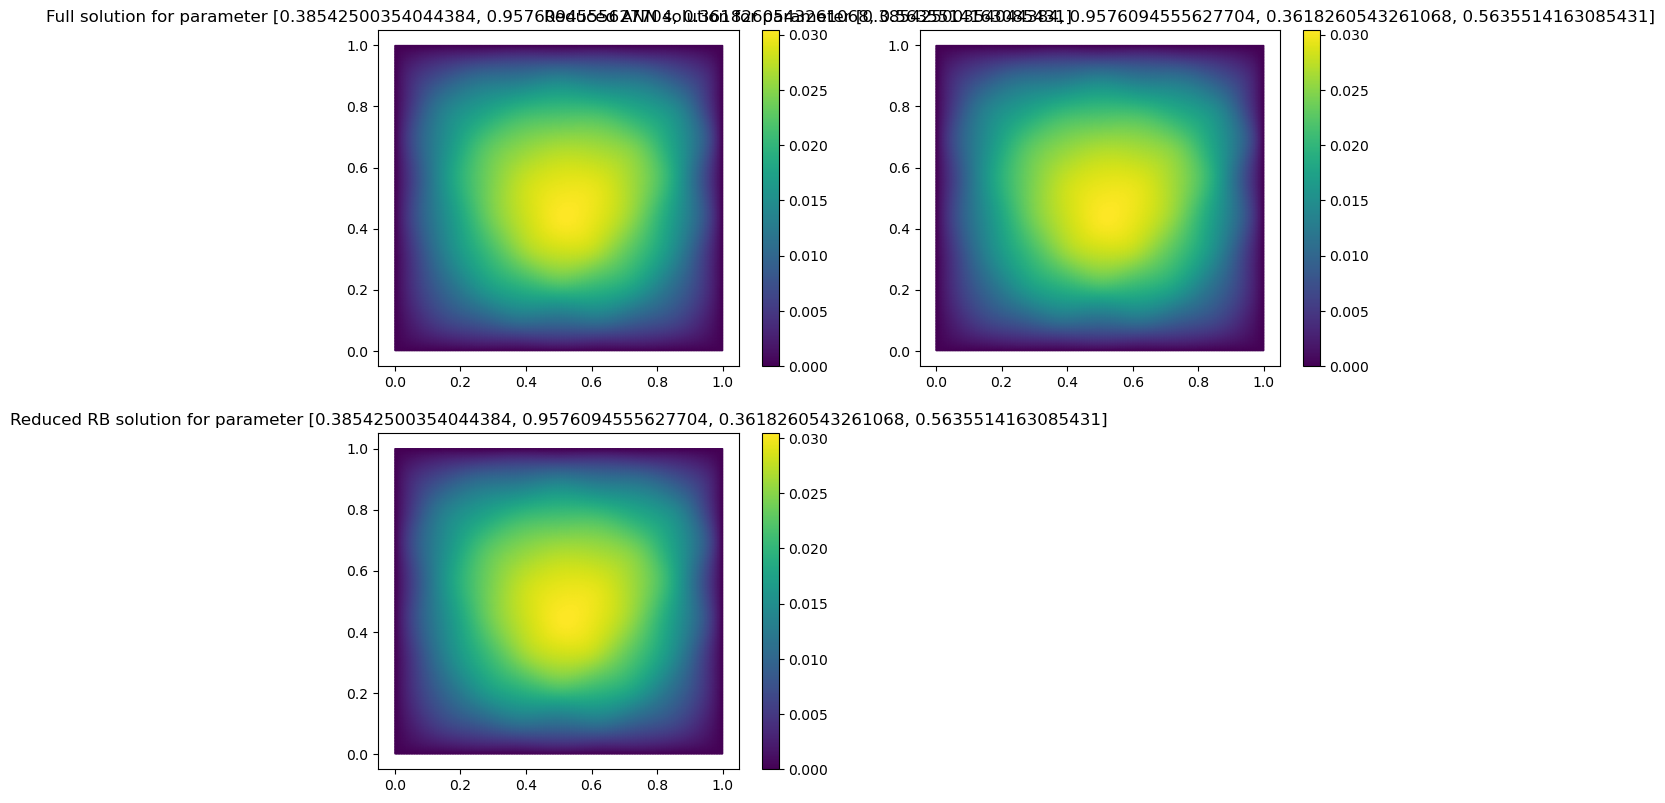

In [7]:
# Visualize solutions

#mu = parameter_space.sample_randomly()
mu = [0.38542500354044384, 0.9576094555627704, 0.3618260543261068, 0.5635514163085431]

U = fom.solve(mu)
U_ann_red = ann_rom.solve(mu)
U_ann_red_recon = ann_reductor.reconstruct(U_ann_red)
U_rb_red = rb_rom.solve(mu)
U_rb_red_recon = rb_reductor.reconstruct(U_rb_red)

fom.visualize(
    (U, U_ann_red_recon, U_rb_red_recon),
    legend = (
        f"Full solution for parameter {mu}",
        f"Reduced ANN solution for parameter {mu}",
        f"Reduced RB solution for parameter {mu}",
    ),
)

### Testing

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

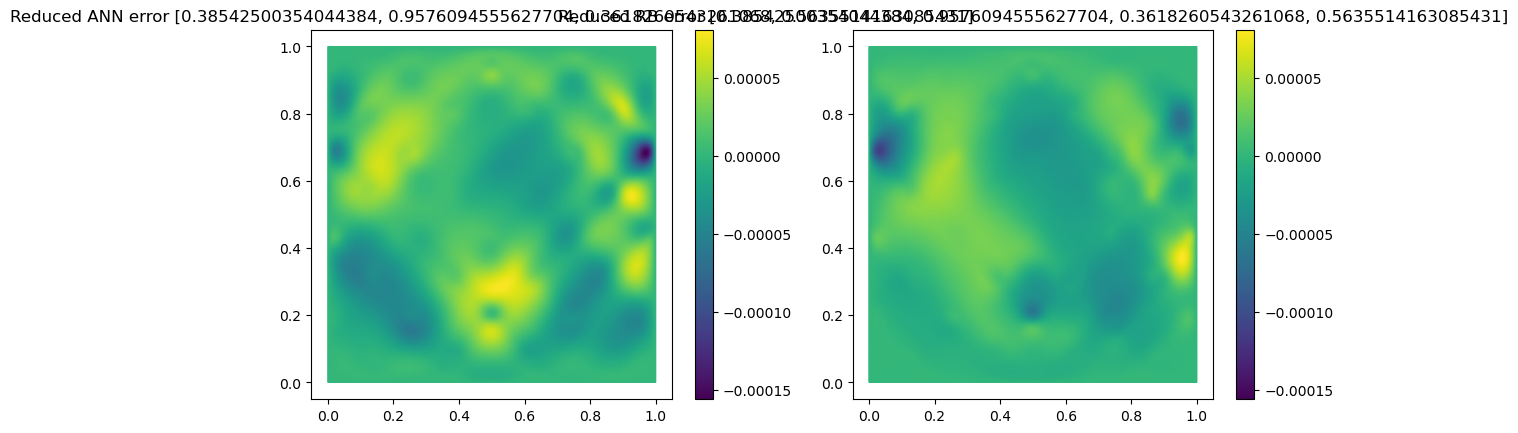

In [8]:
# Error Testing

#mu = [0.1,1.,0.1,1]
#mu = parameter_space.sample_randomly()
mu = [0.38542500354044384, 0.9576094555627704, 0.3618260543261068, 0.5635514163085431]

U = fom.solve(mu)
U_ann_red = ann_rom.solve(mu)
U_ann_red_recon = ann_reductor.reconstruct(U_ann_red)
U_rb_red = rb_rom.solve(mu)
U_rb_red_recon = rb_reductor.reconstruct(U_rb_red)

fom.visualize(
    (U - U_ann_red_recon, U - U_rb_red_recon),
    legend = (
        f"Reduced ANN error {mu}",
        f"Reduced RB error {mu}",
    ),
)